In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
IMG_SHAPE = (28, 28,1)
BATCH_SIZE = 100

# Size of the noise vector
NOISE_DIM = 128

# Discriminator

In [3]:
def conv_block(
    x,
    filters,
    activation=None,
    drop_value = None,
    use_batchnorm = None,
    strides = (2,2),
    kernel_size = (5,5),
    padding="same"
):

  x = layers.Conv2D(filters,kernel_size,strides,padding)(x)
  
  
  if use_batchnorm:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if drop_value:
    x = layers.Dropout(drop_value)(x)
  
  return x


def get_discriminator():

  x = keras.Input(IMG_SHAPE)

  x_32 = layers.ZeroPadding2D(padding=(2,2))(x)

  x_16 = conv_block(x_32,
                    64,
                    activation=layers.LeakyReLU(0.2),
                    drop_value = None,
                    use_batchnorm = None,
                    strides = (2,2),
                    kernel_size = (5,5),
                    padding="same")
  
  x_8 = conv_block(x_16,
                    128,
                    activation=layers.LeakyReLU(0.2),
                    drop_value = 0.3,
                    use_batchnorm = None,
                    strides = (2,2),
                    kernel_size = (5,5),
                    padding="same")
  
  x_4 = conv_block(x_8,
                    256,
                    activation=layers.LeakyReLU(0.2),
                    drop_value = 0.3,
                    use_batchnorm = False,
                    strides = (2,2),
                    kernel_size = (5,5),
                    padding="same")

  x_2 = conv_block(x_4,
                    512,
                    activation=layers.LeakyReLU(0.2),
                    drop_value = None,
                    use_batchnorm = None,
                    strides = (2,2),
                    kernel_size = (5,5),
                    padding="same")
  
  flattened = layers.Flatten()(x_2)
  dropout = layers.Dropout(0.2)(flattened)
  prediction = layers.Dense(1)(dropout)

  model = keras.Model(inputs=x,outputs=prediction)
  return model


discriminator = get_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0     

# Generator

In [4]:
def upsample(
    x,
    filters,
    activation = None,
    kernel_size=(3,3),
    strides =(1,1),
    upsample_size = (2,2),
    padding = "same",
    use_bn = None,
    drop_value = None
):

  x = layers.UpSampling2D(upsample_size)(x)
  x = layers.Conv2D(filters,kernel_size,strides,padding=padding)(x)

  if use_bn:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if drop_value:
    x = layers.Dropout(drop_value)(x)

  return x


def create_generator():

  noise = keras.Input(shape=(NOISE_DIM,))
  first_layer = layers.Dense(4*4*256)(noise)
  first_layer = layers.BatchNormalization()(first_layer)
  first_layer = layers.LeakyReLU(0.2)(first_layer)
  reshaped = layers.Reshape((4,4,256))(first_layer)
  
  up1  =  upsample(
                  reshaped,
                  128,
                  activation = layers.LeakyReLU(0.2),
                  kernel_size=(3,3),
                  strides =(1,1),
                  upsample_size = (2,2),
                  padding = "same",
                  use_bn = True,
                  drop_value = None
              )
  
  up2 =  upsample(
                  up1,
                  64,
                  activation = layers.LeakyReLU(0.2),
                  kernel_size=(3,3),
                  strides =(1,1),
                  upsample_size = (2,2),
                  padding = "same",
                  use_bn=True,
                  drop_value = None
              )

  up3 =  upsample(
                  up2,
                  1,
                  activation = layers.Activation("tanh"),
                  kernel_size=(3,3),
                  strides =(1,1),
                  upsample_size = (2,2),
                  padding = "same",
                  use_bn=True,
                  drop_value = None
              )
  
  image = layers.Cropping2D(cropping=((2, 2), (2, 2)))(up3)

  model = keras.Model(inputs=noise,outputs=image)

  return model

generator = create_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              528384    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         2950

# Model

In [5]:
class WGAN(keras.Model):

  def __init__(self,generator,discriminator,latent_dim=128,disc_steps=3,gp_weight=10,**kwargs):
    super(WGAN,self).__init__(**kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim
    self.d_steps = disc_steps
    self.gp_weight = gp_weight
    # self.generator_loss_tracker = keras.metrics.Mean(name="generator_loss")
    # self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")


  
  # def metrics(self):
  #   return [
  #           self.generator_loss_tracker,
  #           self.discriminator_loss_tracker
  #   ]

  def gradient_penalty(self,batch_size,real_image,fake_image):

    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_image - real_image 
    interpolated = real_image+diff*alpha

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolated)
      pred = self.discriminator(interpolated,training=True)
    
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp


  def compile(self, d_optimizer, g_optimizer):
    super(WGAN,self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer



  @tf.function
  def train_step(self, real_images):

    if isinstance(real_images, tuple):
      real_images = real_images[0]


    batch_size = tf.shape(real_images)[0]

    for i in range(self.d_steps):

      z = tf.random.normal([batch_size,self.latent_dim])

      with tf.GradientTape() as tape:

        fake_img = self.generator(z,training=True)
        fake_pred = self.discriminator(fake_img,training=True)
        real_pred = self.discriminator(real_images,training=True)
        gp  =  self.gradient_penalty(batch_size,real_images,fake_img)

        disc_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred)
        d_loss = disc_loss + gp * self.gp_weight

      d_grads = tape.gradient(d_loss,self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))

    z = tf.random.normal([batch_size,self.latent_dim])
    with tf.GradientTape() as tape:
      
      fake_img = self.generator(z,training=True)
      fake_pred = self.discriminator(fake_img,training=True)
      
      gen_loss = -tf.reduce_mean(fake_pred)

    g_grads = tape.gradient(gen_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
    
    # self.generator_loss_tracker.update_state(gen_loss)
    # self.discriminator_loss_tracker.update_state(d_loss)

    return {"d_loss": d_loss, "g_loss": gen_loss}



In [7]:
(train_images, _), (test_images, _) = keras.datasets.fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")
train_images = np.concatenate([train_images,test_images])
# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5
train_images.shape

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


(70000, 28, 28, 1)

In [ ]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)



wgan = WGAN(
    generator,
    discriminator,
    latent_dim=NOISE_DIM,
    disc_steps=3
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=2)

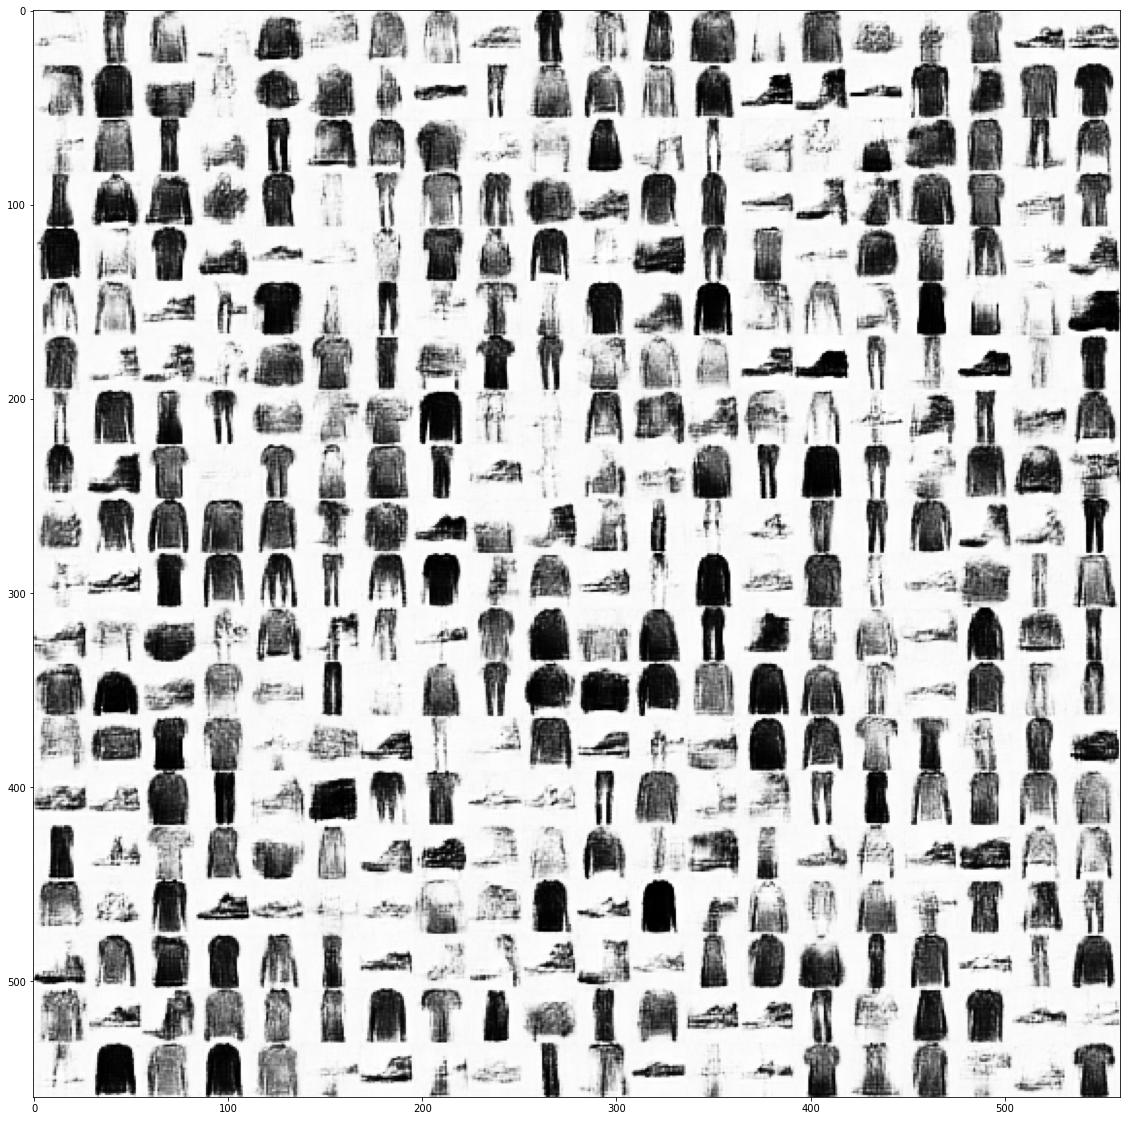

In [9]:
def plot_generated(x=20,y=20,fig_size=(20,20)):
  import matplotlib.pyplot as plt
  imgs = wgan.generator(np.random.normal(size=(x*y,NOISE_DIM)))
  imgs = imgs.numpy()
  train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
  imgs = imgs.reshape(imgs.shape[0], 28,28).astype("float32")
  imgs = (imgs*127.5) +127.5
  figure = np.zeros(shape=(x*28,y*28),dtype=np.float32)
  for i in range(x):
    for j in range(y):
      figure[i*28:(i+1)*28,j*28:(j+1)*28] = -1* (imgs[i*y+j]-1)
  
  plt.figure(figsize=fig_size)
  plt.imshow(figure,cmap="Greys_r")

plot_generated(20,20)